# Evaluate services

This notebook shows the basic communication with the DSA sensors. It uses the helper functions in ```wsg_50_hw```

Simply run

```ipython
?get_dsa_matrices
?dsa_msg_to_array
```

Alternatively, you can directly use the ```PlotDSAHandle``` that uses these functions internally.

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
from tqdm.notebook import tqdm, trange
import seaborn as sns
import rospy
from IPython import display
from wsg_50_msgs.srv import GetDsa, GetDsaRequest
from wsg_50_hw import get_dsa_matrices, get_dsa_cop, PlotDSAHandle

np.set_printoptions(precision=5, suppress=True)

%load_ext autoreload
%autoreload 2

In [2]:
# default constants for exmaple usage
# WSG_NODE_NAME="/wsg_50_hw"
WSG_NODE_NAME="/hrr_cobot/gripper"
DSA_SERVICE = f'{WSG_NODE_NAME}/get_dsa_data'
STATUS_TOPIC = f'{WSG_NODE_NAME}/status'

In [3]:
rospy.init_node("eval_gripper")
rospy.wait_for_service(DSA_SERVICE)
get_dsa_data_srv = rospy.ServiceProxy(DSA_SERVICE, GetDsa)

In [4]:
srv_data = get_dsa_data_srv(GetDsaRequest(timeout=6000))
srv_data

dsa_finger0: 
  height: 14
  width: 6
  dsa_values: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dsa_finger1: 
  height: 14
  width: 6
  dsa_values: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
process_time: 156.18899536132812

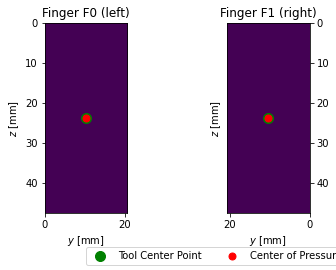

In [5]:
plot_handle = PlotDSAHandle(DSA_SERVICE, STATUS_TOPIC)

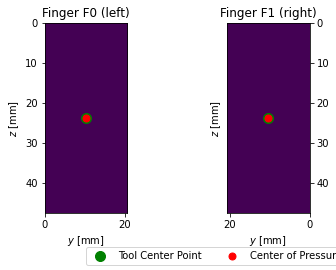

[ 0.       0.       0.       0.      -0.       3.14159]


In [14]:
errs = []
for _ in range(10):
    display.clear_output(wait=True)
    plot_handle.update()
    errs.append(plot_handle.error)
    display.display(plot_handle.fig)
    rospy.sleep(1.0)
    print(plot_handle.error)

In [16]:
errs

[array([ 0.     ,  0.     ,  0.     ,  0.     , -0.     ,  3.14159]),
 array([ 0.     , -0.0042 ,  0.01091,  0.     , -1.20218, -1.65799]),
 array([ 0.     , -0.0032 ,  0.00604,  0.     , -1.08139, -1.6851 ]),
 array([ 0.     , -0.00355, -0.00513,  0.     ,  0.96257, -1.67386]),
 array([ 0.     , -0.00377, -0.01043,  0.     ,  1.22218, -1.66784]),
 array([ 0.     , -0.00353, -0.00985,  0.     ,  1.22518, -1.6745 ]),
 array([ 0.     , -0.00361,  0.00141,  0.     , -0.36987, -1.6722 ]),
 array([ 0.     , -0.00367,  0.00895,  0.     , -1.17988, -1.67044]),
 array([ 0.     , -0.00344, -0.00499,  0.     ,  0.96473, -1.6772 ]),
 array([ 0.     ,  0.     ,  0.     ,  0.     , -0.     ,  3.14159])]

In [7]:
import tf2_ros
import spatialmath as sm
tfBuffer = tf2_ros.Buffer()
listener = tf2_ros.TransformListener(tfBuffer)

def get_transform(target, source):    
    trans = None
    for _ in range(1000):
        try:
            trans = tfBuffer.lookup_transform(target, source, rospy.Time(0))
            break
        except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException):
            rate.sleep(1e-3)
            continue    
    T_t_s = sm.SE3(trans.transform.translation.x, trans.transform.translation.z, trans.transform.translation.z)
    q = sm.quaternion.Unitquaternion(trans.transform.translation.w, 
                                     [trans.transform.rotation.x, trans.transform.rotation.y, trans.transform.rotation.z])
    T_t_s.A[:3, :3] = q.R
    return T_t_s, q

In [18]:
get_transform("tcp", "wsg_50_tcp")

NameError: name 'rate' is not defined

# Publish error as twist message for visualization

error obtained from handle is given in gripper TCP frame

## degbug / testing procedure

- generate TCP message as ```geometry_msgs/TwistStamped```
- visualize in Rviz
- vizualize command in Rviz in robot tcp frame


In [9]:
from geometry_msgs.msg import TwistStamped
error_publisher = rospy.Publisher("gripper_error", TwistStamped, queue_size=100)
pseudo_command_publisher = rospy.Publisher("sns_cmd", TwistStamped, queue_size=100)

In [10]:
def arr2twist(arr, tw):
    # type: (np.ndarray, TwistStamped) -> TwistStamped
    tw.header.stamp = rospy.Duration(rospy.get_time())
    tw.twist.linear.x = arr[0]
    tw.twist.linear.y = arr[1]
    tw.twist.linear.z = arr[2]
    tw.twist.angular.x = arr[3]
    tw.twist.angular.y = arr[4]
    tw.twist.angular.z = arr[5]
    return tw

In [11]:
err_tw = TwistStamped()
err_tw.header.frame_id = "wsg_50_tcp"
cmd_tw = TwistStamped()
cmd_tw.header.frame_id = "tcp_controller"

In [ ]:
for _ in range(120):
    display.clear_output(wait=True)
    plot_handle.update()
    error_publisher.publish(arr2twist(plot_handle.error, err_tw))
    display.display(plot_handle.fig)

## Run timing benchmark for 

Evaluate average process time for dsa service below ```get_dsa_data_srv```


In [ ]:
def run_dsa_benchmark(nb_runs=50):
    dt = []
    # benchmark access time
    for i in trange(nb_runs):
        try:
            dsa_data = get_dsa_data_srv(GetDsaRequest(timeout=1000))
            dt.append(dsa_data.process_time)
        except:
            pass
    return np.array(dt)

In [ ]:
tmp = run_dsa_benchmark(3)
print(f"Run time: mean:={np.mean(tmp)} [ms] (~{1e3/np.mean(tmp)}[Hz]), covariance: {np.cov(tmp)} [ms]")